## Random forest model for BSC graduation rates based on Freshman fall semester info

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, normalize
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance, plot_partial_dependence

In [4]:
df = pd.read_csv('../../data/anonymized_bsc_dataPVZ.csv', low_memory=False)

In [5]:
#only select the 4 cohorts of interest
df_4 = df.loc[(df['Cohort'] == '14/FA') | (df['Cohort'] == '15/FA') | (df['Cohort'] == '16/FA')
              | (df['Cohort'] == '17/FA')]
df_4 = df_4.dropna(subset=['Sttr Term'])
#df_4

In [6]:
#pull out just the avg gpa of the 1st semester
df_sorted = df_4.sort_values(by = 'Sttr Term', ascending = True)
df_dropped = df_sorted.drop_duplicates(subset=['alt_id'])

In [7]:
#turning gpa data frame into a dictionary to be able to map it to our original dataframe
gpa_map = df_dropped.set_index('alt_id')['Sttr Term Gpa'].to_dict()

#making a new column in original data frame by mapping gpa
df_4['ffall_gpa'] = df_4['alt_id'].map(gpa_map)

In [8]:
#make new df of just basic freshman info
df_simple = df_4.sort_values(by = 'Sttr Term', ascending = True)
df_simple = df_simple.drop_duplicates(subset=['alt_id'])

In [9]:
#drop all the extra columns that won't matter
df_simple = df_simple.drop(columns = ['Sttr Term', 'course_#', 'course_title', 'Sttr Stu Credits', 'Sttr Attempted Cred', 'faculty',
                                      'Sttr Stu Final Grades', 'Sttr Term Gpa', 'SP1 Enr', 'SP1 Class', 'SP1 Major', 'FA2 Enr', 'FA2 Class',
                                      'FA2 Major', 'FA3 Enr', 'FA3 Class', 'FA4 Enr', 'FA4 Class', 'FA4 Major', 'FA5 Enr', 'faculty', 
                                      'FA3 Major', 'FA5 Class', 'FA5 Major', 'alt_id','FA6 Enr', 'FA6 Class', 'FA6 Major', 'Grad Term', 
                                      'Grad Year', 'Grad Major'])

In [10]:
#set X & y, do TTS
y = df_simple['Graduated']
X = df_simple.drop(columns=['Graduated'], axis=1)

In [11]:
#recode the graduation column so that N = 0 & Y = 1
mapping = {'N': 0, 'Y': 1}
y = y.map(mapping)

#initial TTS
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=.25, random_state=2021)
#generate validation set
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.25, random_state=2021)

In [12]:
# need to OHE categorical & scale continuous
num_cols = list(X_train.select_dtypes('number').columns)
print (num_cols)
cat_cols = list(X_train.select_dtypes('object').columns)
print (cat_cols)


['Sttr Cmpl Cred', 'ffall_gpa']
['Sttr Student Load', 'Cohort']


In [13]:
#scale both train & test continuous variables

# Instantiate StandardScaler
scaler = StandardScaler()
# fit on Imputed training data
scaler.fit(X_train[num_cols])
# transform training, validation, & tr data
X_train_scaled = pd.DataFrame(scaler.transform(X_train[num_cols]), columns=num_cols)
X_val_scaled = pd.DataFrame(scaler.transform(X_val[num_cols]), columns=num_cols)
X_tr_scaled = pd.DataFrame(scaler.transform(X_tr[num_cols]), columns=num_cols)

In [14]:
#encode just categorical features
# fit on categorical data
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
ohe.fit(X_train[cat_cols])
# transform training and validation data
X_train_encoded = ohe.transform(X_train[cat_cols])
X_val_encoded = ohe.transform(X_val[cat_cols])
X_tr_encoded = ohe.transform(X_tr[cat_cols])

In [15]:
#convert categorical back to dataframe
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=ohe.get_feature_names())
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=ohe.get_feature_names())
X_tr_encoded_df = pd.DataFrame(X_tr_encoded, columns=ohe.get_feature_names())

In [16]:
#concatenate the two back together again
X_train_df = pd.concat([X_train_scaled, X_train_encoded_df], axis=1)
X_val_df = pd.concat([X_val_scaled, X_val_encoded_df], axis=1)
X_tr_df = pd.concat([X_tr_scaled, X_tr_encoded_df], axis=1)

### Random forests classifier

In [17]:
#Instantiate the RF model

rf_model = RandomForestClassifier(n_estimators = 100) 

In [18]:
rf_model.fit(X_train_df, y_train)

RandomForestClassifier()

In [19]:
# Training accuracy score
rf_model.score(X_train_df, y_train)

0.8643031784841075

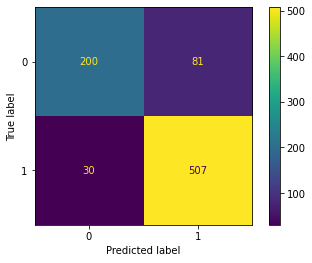

In [20]:
#plot confusion matrix
plot_confusion_matrix(rf_model, X_train_df, y_train)

In [21]:
rf_model.feature_importances_

array([0.17812146, 0.75996652, 0.00076791, 0.00132089, 0.01607646,
       0.01434907, 0.01018182, 0.01921587])

[0.17812146 0.75996652 0.00076791 0.00132089 0.01607646 0.01434907
 0.01018182 0.01921587]


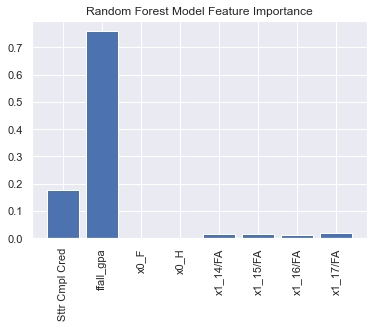

In [22]:
#visualize important features in this RF model
features = X_train_df.columns
print(rf_model.feature_importances_)
feature_df = pd.DataFrame({'Importance':rf_model.feature_importances_, 'Features': features })
sns.set()
plt.bar(feature_df['Features'], feature_df['Importance'])
plt.xticks(rotation=90)
plt.title('Random Forest Model Feature Importance')
plt.show()

### gridsearch for RF model

In [23]:
# Create Param Grid 
param_grid = {'n_estimators': [90, 100, 110],
                'max_depth': [10, 15, 20],
                'min_samples_leaf': [6, 7, 8]}

In [24]:
# Create GridSearchCV
rf_gs = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring='accuracy')

In [25]:
rf_gs.fit(X_train_df, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [6, 7, 8],
                         'n_estimators': [90, 100, 110]},
             scoring='accuracy')

In [26]:
best_model = rf_gs.best_estimator_

In [27]:
rf_gs.best_params_

{'max_depth': 15, 'min_samples_leaf': 7, 'n_estimators': 90}

The best parameters from the grid search are (actually, they're all pretty comparable):
{'max_depth': 10, 'min_samples_leaf': 7, 'n_estimators': 75}
{'max_depth': 15, 'min_samples_leaf': 7, 'n_estimators': 100}
{'max_depth': 10, 'min_samples_leaf': 8, 'n_estimators': 100}

### running RF w/ best params & eval on validation, then test sets

In [28]:
rf_best = RandomForestClassifier(max_depth= 15, min_samples_leaf= 7, n_estimators= 100) 

In [29]:
rf_best.fit(X_train_df, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=7)

In [30]:
# Training accuracy score
rf_best.score(X_train_df, y_train)

0.7579462102689487

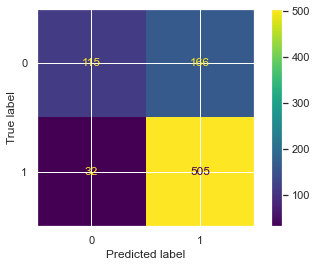

In [31]:
#plot confusion matrix
plot_confusion_matrix(rf_best, X_train_df, y_train)

In [32]:
# test accuracy score
rf_best.score(X_val_df, y_val)

0.6959706959706959

#### Calculating feature importance

In [ ]:
result = permutation_importance(rf_best, X_train_df, y_train, n_repeats=10, random_state=0)
result_mean = result.importances_mean
result_std = result.importances_std

In [ ]:
#visualize important features in this RF model
features = X_train_df.columns

feature_df = pd.DataFrame({'Importance': result_mean, 'Features': features })
sns.set()
plt.bar(feature_df['Features'], feature_df['Importance'], yerr=result_std)
plt.xticks(rotation=45)
plt.title('Random Forest Model Feature Importance')
plt.show()

#### Prediction: prepare all data for user model fitting

In [ ]:
#first, transform X & y data using the OHE & SS settings applied initially

# pull out the continuous columns of X
X_num_cols = list(X.select_dtypes('number').columns)

# pull out the categorical columns of X
X_cat_cols = list(X.select_dtypes('object').columns)

# Instantiate StandardScaler
new_scaler = StandardScaler()

# fit on Imputed training data
new_scaler.fit(X[X_num_cols])

# transform all continuous X data
X_scaled = pd.DataFrame(new_scaler.transform(X[X_num_cols]), columns=X_num_cols)

# OHE categorical columns for X data
X_encoded = ohe.transform(X[X_cat_cols])

#convert categorical & continuous back to dataframe
X_encoded_df = pd.DataFrame(X_encoded, columns=ohe.get_feature_names())
X_scaled_df = pd.DataFrame(new_scaler.transform(X[X_num_cols]), columns=X_num_cols)

#concatenate the two back together again X
X_df = pd.concat([X_scaled_df, X_encoded_df], axis=1)

#X_df.head()

In [ ]:
#drop 2 columns w/ no value: 'x0_F' & 'x0_H'
X_df = X_df.drop(columns = ['x0_F', 'x0_H'], axis=1)
#X_df

In [ ]:
#Next, fit the model on all available data
rf_best = RandomForestClassifier(max_depth= 15, min_samples_leaf= 7, n_estimators= 100) 
rf_best.fit(X_df, y)

# accuracy score full data
rf_best.score(X_df, y)

In [ ]:
#X_df.head()

In [ ]:
# define one new input array (=user input) + default
#values are based on fall freshman semester
#First item is # units completed, 2nd item is semester gpa
X_in = [[3, 3.5]]
X_defaults = [[0,0,1,0]]

In [ ]:
#transform user input using scalers & encoders from above
#pull out just 1st element in prep for scaling
X_1 = [X_in[0][0:2]]

X_1_scaled = pd.DataFrame(new_scaler.transform(X_1))

In [ ]:
X_1_scaled

In [ ]:
X_input = np.append(X_1_scaled, X_defaults, axis=1)
X_input

##### Making prediction

In [ ]:
#make a prediction
y_out = rf_best.predict_proba(X_input)
print("Predicted=%s" % (y_out))

In [ ]:
y_out[0, 1].round(3)

#### function for deployment

In [ ]:
#function for producing output
#First item is # units completed, 2nd item is semester gpa
inputs = []
def get_grad(inputs):
    X_defaults = [[0,0,1,0]]
    
    #scale user input
    X_in = [inputs[0][0:2]]
    X_1_scaled = pd.DataFrame(new_scaler.transform(X_in))
    
    #concatenate input + defaults
    X_input = np.append(X_1_scaled, X_defaults, axis=1)
    
    #pass to model
    rf_best = RandomForestClassifier(max_depth= 15, min_samples_leaf= 7, n_estimators= 100) 
    rf_best.fit(X_df, y)
    
    #make a prediction
    y_out = rf_best.predict_proba(X_input)
    print('Your chance of not graduating is {} \n and the chance of graduating is {}'
          .format(y_out[0, 0].round(3), y_out[0, 1].round(3)))
    

In [ ]:
mylist = [3.25,3]

In [ ]:
get_grad([mylist])

In [ ]:
file

In [ ]:
# save the model to disk
filename = 'final_rf_model.sav'
file = open(filename, 'wb')
pickle.dump(rf_best, file)
file.close()

In [ ]:
# save the scaler to disk
filename = 'scaler.sav'
pickle.dump(new_scaler, open(filename, 'wb'))